In [1]:
import sys
from itertools import count
from torch import autograd
from torch_geometric.utils import dense_to_sparse
import copy
from collections import defaultdict

sys.path.append('../../')

from src.models.gcn import *
from src.utils.datasets import *
from src.models.trainable import *
from src.attacks.greedy_gd import *

print(sys.executable)

/home/wcorcoran/anaconda3/envs/mesp/bin/python


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# dataset_directory = "../Cora"
cora_dataset = Planetoid(root='', name='Cora')
data = cora_dataset[0].to(device)
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [4]:
model = GCN(data.x.shape[1], cora_dataset.num_classes, [16]).to(device)

In [5]:
model.reset_parameters()
train = Trainable(model)
train.fit(data, 200)

Epoch 0, Train Loss - 4.207466125488281, Val Loss - 3.279747486114502, Val Accuracy - 0.146
Epoch 20, Train Loss - 0.35072535276412964, Val Loss - 1.3116512298583984, Val Accuracy - 0.719
Epoch 40, Train Loss - 0.14409838616847992, Val Loss - 1.5798776149749756, Val Accuracy - 0.754
Epoch 60, Train Loss - 0.12513774633407593, Val Loss - 1.8407700061798096, Val Accuracy - 0.747
Epoch 80, Train Loss - 0.09324123710393906, Val Loss - 1.8517628908157349, Val Accuracy - 0.758
Epoch 100, Train Loss - 0.044056717306375504, Val Loss - 1.9885574579238892, Val Accuracy - 0.738
Epoch 120, Train Loss - 0.07034691423177719, Val Loss - 2.160252094268799, Val Accuracy - 0.754
Epoch 140, Train Loss - 0.06533597409725189, Val Loss - 2.157578706741333, Val Accuracy - 0.752
Epoch 160, Train Loss - 0.044007252901792526, Val Loss - 2.2697439193725586, Val Accuracy - 0.754
Epoch 180, Train Loss - 0.02799821086227894, Val Loss - 2.4961071014404297, Val Accuracy - 0.75
Epoch 200, Train Loss - 0.02145946770906

In [6]:
# Get initial accuracy
initial_loss, initial_accuracy = train.test(data)
print(f"Initial Accuracy: {initial_accuracy}")
print(f"Initial Loss: {initial_loss}")

Initial Accuracy: 0.754
Initial Loss: 2.2614994049072266


In [40]:
# run 5 metattacks w/ ptb of 1
amts = defaultdict(int)

for _ in range(10):
    attacker = Metattack(data, device=device)
    attacker.setup_surrogate(model,
                         labeled_nodes=data.train_mask,
                         unlabeled_nodes=data.test_mask, lambda_=0.)
    attacker.reset()
    attacker.attack(0.1)

    for edge in attacker._added_edges.keys():
        amts[edge] += 1

Peturbing graph...:   0%|          | 0/527 [00:00<?, ?it/s]

Peturbing graph...:   0%|          | 0/527 [00:00<?, ?it/s]

Peturbing graph...:   0%|          | 0/527 [00:00<?, ?it/s]

Peturbing graph...:   0%|          | 0/527 [00:00<?, ?it/s]

Peturbing graph...:   0%|          | 0/527 [00:00<?, ?it/s]

Peturbing graph...:   0%|          | 0/527 [00:00<?, ?it/s]

Peturbing graph...:   0%|          | 0/527 [00:00<?, ?it/s]

Peturbing graph...:   0%|          | 0/527 [00:00<?, ?it/s]

Peturbing graph...:   0%|          | 0/527 [00:00<?, ?it/s]

Peturbing graph...:   0%|          | 0/527 [00:00<?, ?it/s]

In [41]:
amts

defaultdict(int,
            {(57, 2410): 8,
             (23, 2513): 4,
             (7, 2603): 8,
             (23, 2697): 8,
             (115, 2617): 2,
             (23, 2255): 1,
             (21, 2609): 3,
             (49, 2417): 4,
             (13, 2699): 1,
             (79, 2482): 10,
             (54, 730): 4,
             (4, 2602): 10,
             (11, 2438): 1,
             (23, 2142): 7,
             (23, 322): 3,
             (27, 2411): 2,
             (131, 2532): 5,
             (23, 273): 6,
             (76, 2173): 2,
             (32, 1056): 2,
             (19, 2477): 3,
             (54, 1397): 2,
             (29, 2566): 3,
             (98, 2683): 2,
             (62, 1938): 2,
             (54, 63): 9,
             (58, 2512): 5,
             (61, 167): 2,
             (54, 926): 3,
             (54, 2639): 3,
             (63, 2611): 1,
             (10, 2437): 4,
             (66, 2337): 2,
             (86, 1057): 5,
             (96, 2258): 3,
        

In [47]:
sorted_list = sorted(amts.items(), key=lambda item: item[1], reverse=True)
sorted_keys = [key for key, value in sorted_list]

In [49]:
edges_to_add = sorted_keys

In [50]:
from torch_geometric.utils import dense_to_sparse, to_networkx, from_networkx
import networkx as nx

In [52]:
G = to_networkx(data, to_undirected=True)
initial_edge_count = G.number_of_edges() // 2
ptb_rate = 0.3
budget = int(ptb_rate * initial_edge_count)

In [21]:
# import sys
# import torch
# from itertools import count
# from torch_geometric.utils import dense_to_sparse, to_networkx, from_networkx
# import random
# import numpy as np
# import networkx as nx

# # Convert the graph to NetworkX for manipulation
# G = to_networkx(data, to_undirected=True)

# # Store initial edge count
# initial_edge_count = G.number_of_edges() // 2
# print('num edges: ', initial_edge_count)

# ptb_rate = 0.3

# # Degree-based Edge Addition
# budget = int(ptb_rate * initial_edge_count)  # Define the number of edges to add

# # Calculate the degree of each node
# degrees = dict(G.degree())

# def sum_degs(edge):
#     return degrees[edge[0]]+ degrees[edge[1]]

# # Group nodes by degree range (e.g., group nodes with degrees within ±1)
# degree_bins = {}
# for node, degree in degrees.items():
#     bin_key = degree // 2  # Bin nodes by ranges of 2
#     if bin_key not in degree_bins:
#         degree_bins[bin_key] = []
#     degree_bins[bin_key].append(node)

# # Generate potential edges between nodes in the same degree bin
# edges_to_add = []
# for bin_nodes in degree_bins.values():
#     if len(bin_nodes) > 1:
#         # Randomly pair nodes within the same bin
#         random.shuffle(bin_nodes)
#         for i in range(len(bin_nodes)):
#             for j in range(i + 1, len(bin_nodes)):
#                 if not G.has_edge(bin_nodes[i], bin_nodes[j]) and i != j:
#                     edges_to_add.append(((bin_nodes[i], bin_nodes[j]), sum_degs((bin_nodes[i], bin_nodes[j]))))
                    
# edges_to_add.sort(key=lambda x:-x[1])

In [23]:
print(len(edges_to_add))
print(budget)

169
65


In [31]:
print(edges_to_add)

[(54, 63), (28, 131), (79, 2482), (58, 1643), (58, 1418), (62, 2437), (23, 225), (57, 2410), (7, 2603), (115, 187), (4, 2602), (54, 1132), (58, 654), (32, 2438), (58, 1454), (58, 2672), (13, 1014), (23, 422), (23, 131), (58, 198), (76, 959), (23, 2513), (23, 2697), (23, 2142), (54, 361), (13, 2699), (76, 2171), (11, 1056), (66, 2566), (58, 1018), (58, 1559), (68, 361), (131, 355), (131, 545), (58, 2417), (96, 2174), (49, 2417), (4, 500), (136, 2637), (57, 2411), (21, 2699), (49, 1084), (49, 1582), (19, 2477), (34, 2683), (98, 1938), (101, 1208), (136, 2532), (21, 2603), (7, 2602), (115, 2433), (58, 187), (96, 2258), (66, 2417), (68, 2683), (54, 545), (106, 2149), (23, 2551), (21, 2411), (23, 1310), (49, 1057), (50, 2513), (54, 225), (27, 1014), (19, 2609), (115, 986), (115, 1684), (58, 2681), (82, 422), (58, 2646), (58, 585), (115, 2142), (34, 2682), (58, 1194), (101, 378), (115, 1024), (131, 721), (54, 1437), (72, 2675), (131, 1938), (58, 2264), (115, 1132), (49, 2513), (76, 2697), (5

In [53]:
def two_phase_attack(split):
    diff_threshold = 0.01
    first_phase_edges = int(budget * split)
    second_phase_percent = ptb_rate * (1 - split) * 1/2
    print(second_phase_percent)
    accuracies = []
    G = to_networkx(data, to_undirected=True)
    
    data_copy = copy.copy(data)
    i, j = 0, 0 # i - number added, j - spot in list
    while i < first_phase_edges:
        u, v = edges_to_add[j]
    
        G.add_edge(u, v)
    
        modified_data = from_networkx(G).to(device)
        modified_data.x = data.x 
        modified_data.y = data.y 
        modified_data.train_mask = data.train_mask
        modified_data.test_mask = data.test_mask
    
        modified_loss, modified_accuracy = train.test(modified_data)
        # print(modified_loss)
    
        # if (abs(modified_loss - initial_loss) / max(modified_loss, initial_loss)) <= diff_threshold:
        if modified_accuracy == initial_accuracy:
            # print(modified_accuracy, i)
            i += 1
            accuracies.append(modified_accuracy)
        else:
            # print(i, 'miss!')
            G.remove_edge(u, v)
            
        j += 1
    
    modified_data = from_networkx(G).to(device)
    modified_data.x = data.x 
    modified_data.y = data.y 
    modified_data.train_mask = data.train_mask
    modified_data.test_mask = data.test_mask
    
    attacker = Metattack(modified_data, device=device)
    attacker.setup_surrogate(model,
                             labeled_nodes=data.train_mask,
                             unlabeled_nodes=data.test_mask, lambda_=0.)
    attacker.reset()
    attacker.attack(second_phase_percent)

    degs = defaultdict(tuple)
    
    for k, v in attacker._added_edges.items():
        degs[v] = (k, True)
        
    for k, v in attacker._removed_edges.items():
        degs[v] = (k, False)
    
    for _, second in degs.items():
        u, v = second[0]
        if second[1]:
            G.add_edge(u, v)
        else:
            G.remove_edge(u, v)
    
        modified_data = from_networkx(G).to(device)
        modified_data.x = data.x 
        modified_data.y = data.y 
        modified_data.train_mask = data.train_mask
        modified_data.test_mask = data.test_mask
    
        modified_loss, modified_accuracy = train.test(modified_data)
    
        accuracies.append(modified_accuracy)

    print(accuracies)
    return accuracies

In [54]:
splits = [0, 0.5, 0.7, 0.9]
split_dic = defaultdict(list)

In [55]:
for s in splits:
    print(s)
    split_dic[s] = two_phase_attack(s)

0
0.15


Peturbing graph...:   0%|          | 0/791 [00:00<?, ?it/s]

[0.755, 0.756, 0.758, 0.759, 0.758, 0.758, 0.758, 0.758, 0.757, 0.757, 0.757, 0.757, 0.757, 0.757, 0.757, 0.756, 0.755, 0.756, 0.756, 0.756, 0.756, 0.756, 0.756, 0.756, 0.756, 0.756, 0.757, 0.757, 0.757, 0.757, 0.757, 0.757, 0.757, 0.758, 0.76, 0.759, 0.759, 0.759, 0.758, 0.758, 0.758, 0.758, 0.756, 0.756, 0.756, 0.756, 0.756, 0.756, 0.757, 0.757, 0.757, 0.757, 0.757, 0.757, 0.757, 0.757, 0.756, 0.756, 0.756, 0.756, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.753, 0.753, 0.753, 0.753, 0.753, 0.753, 0.753, 0.753, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.751, 0.751, 0.752, 0.752, 0.751, 0.751, 0.751, 0.753, 0.753, 0.753, 0.753, 0.753, 0.753, 0.753, 0.753, 0.753, 0.753, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.753, 0.753, 0.753, 0.755, 0.755, 0.755, 0.755, 0.755, 0.755, 0.755, 0.755, 0.755, 0.755, 0.755, 0.755, 0.755, 0.755,

Peturbing graph...:   0%|          | 0/425 [00:00<?, ?it/s]

[0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754

Peturbing graph...:   0%|          | 0/262 [00:00<?, ?it/s]

[0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754

Peturbing graph...:   0%|          | 0/89 [00:00<?, ?it/s]

[0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754

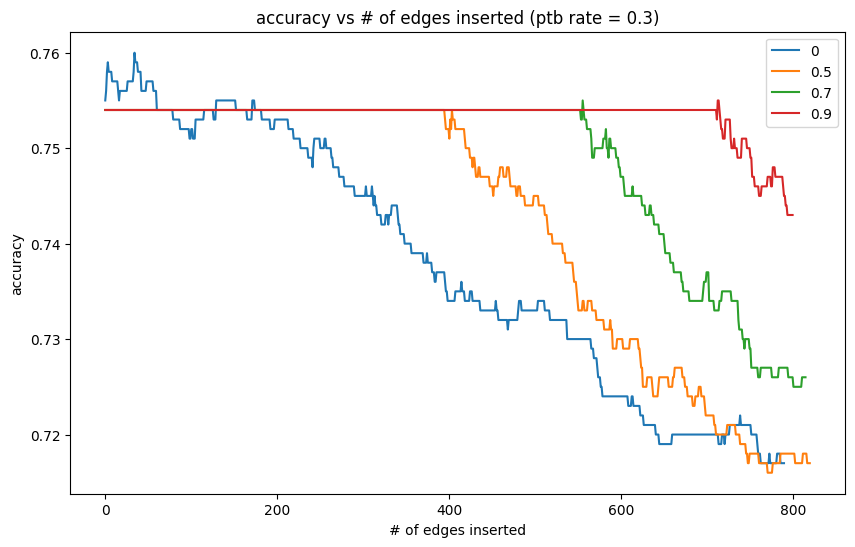

In [56]:
import matplotlib.pyplot as plt

# split_dic2 = copy.copy(split_dic)

# for label, values in split_dic2.items():
#     for i in range(len(values)):
#         split_dic2[label][i] = - abs(values[i] - initial_loss)

plt.figure(figsize=(10, 6))

# Iterate over the dictionary and plot each list
for label, values in split_dic.items():
    plt.plot(values, label=str(label))

plt.xlabel('# of edges inserted')
plt.ylabel('accuracy')
plt.title('accuracy vs # of edges inserted (ptb rate = 0.3)')
plt.legend()

plt.show()

In [21]:
# new_data = handle_new_edges(modified_data, attacker, device)

# loss, acc = train.test(new_data)
# print(f'Loss: {loss}, Acc: {acc}')

torch.Size([2, 11006])
Loss: 2.7860538959503174, Acc: 0.696


In [ ]:
# Randomly select a subset of edges to add
# random.shuffle(edges_to_add)
# edges_to_add = edges_to_add[:num_edges_to_add]

# # Add the selected edges to the graph
# for i, j in edges_to_add:
#     G.add_edge(i, j)

# # Store final edge count
# final_edge_count = G.number_of_edges()

# # Convert back to PyTorch Geometric format
# modified_data = from_networkx(G).to(device)
# modified_data.x = data.x  # Preserve original node features
# modified_data.y = data.y  # Preserve original labels
# modified_data.train_mask = data.train_mask
# modified_data.test_mask = data.test_mask

# # Evaluate the model on the modified graph
# _, modified_accuracy = train.test(modified_data)
# print(f"Modified Accuracy: {modified_accuracy}")

# # Calculate and display the edge statistics
# edge_difference = final_edge_count - initial_edge_count
# print(f"Edges Added: {edge_difference}")
# print(f"Percentage Increase in Edges: {100 * edge_difference / initial_edge_count:.2f}%")

# # Output accuracy change
# accuracy_change = modified_accuracy - initial_accuracy
# print(f"Accuracy Change: {accuracy_change:.4f}")


In [29]:
# Convert the graph to NetworkX for manipulation
G = to_networkx(data, to_undirected=True)

# Store initial edge count
initial_edge_count = G.number_of_edges()

# Degree-based Edge Addition
num_edges_to_add = 200  # Define the number of edges to add

# Calculate the degree of each node
degrees = dict(G.degree())

# Group nodes by degree range (e.g., group nodes with degrees within ±1)
degree_bins = {}
for node, degree in degrees.items():
    bin_key = degree // 2  # Bin nodes by ranges of 2
    if bin_key not in degree_bins:
        degree_bins[bin_key] = []
    degree_bins[bin_key].append(node)

# Generate potential edges between nodes in the same degree bin
edges_to_add = []
for bin_nodes in degree_bins.values():
    if len(bin_nodes) > 1:
        # Randomly pair nodes within the same bin
        random.shuffle(bin_nodes)
        for i in range(len(bin_nodes)):
            for j in range(i + 1, len(bin_nodes)):
                if not G.has_edge(bin_nodes[i], bin_nodes[j]):
                    edges_to_add.append((bin_nodes[i], bin_nodes[j]))


# Randomly select a subset of edges to add
random.shuffle(edges_to_add)
edges_to_add = edges_to_add[:num_edges_to_add]


# Add the selected edges to the graph
for i, j in edges_to_add:
    G.add_edge(i, j)

# Store final edge count
final_edge_count = G.number_of_edges()

# Convert back to PyTorch Geometric format
modified_data = from_networkx(G).to(device)
modified_data.x = data.x  # Preserve original node features
modified_data.y = data.y  # Preserve original labels
modified_data.train_mask = data.train_mask
modified_data.test_mask = data.test_mask

# Evaluate the model on the modified graph
_, modified_accuracy = train.test(modified_data)
print(f"Modified Accuracy: {modified_accuracy}")

# Calculate and display the edge statistics
edge_difference = final_edge_count - initial_edge_count
print(f"Edges Added: {edge_difference}")
print(f"Percentage Increase in Edges: {100 * edge_difference / initial_edge_count:.2f}%")

# Output accuracy change
accuracy_change = modified_accuracy - initial_accuracy
print(f"Accuracy Change: {accuracy_change:.4f}")

Modified Accuracy: 0.728
Edges Added: 200
Percentage Increase in Edges: 3.79%
Accuracy Change: -0.0080


In [30]:
# Convert the graph to NetworkX for manipulation
G = to_networkx(data, to_undirected=True)

# Store initial edge count
initial_edge_count = G.number_of_edges()

# Degree-based Edge Addition
num_edges_to_add = 300  # Define the number of edges to add

# Calculate the degree of each node
degrees = dict(G.degree())

# Group nodes by degree range (e.g., group nodes with degrees within ±1)
degree_bins = {}
for node, degree in degrees.items():
    bin_key = degree // 2  # Bin nodes by ranges of 2
    if bin_key not in degree_bins:
        degree_bins[bin_key] = []
    degree_bins[bin_key].append(node)

# Generate potential edges between nodes in the same degree bin
edges_to_add = []
for bin_nodes in degree_bins.values():
    if len(bin_nodes) > 1:
        # Randomly pair nodes within the same bin
        random.shuffle(bin_nodes)
        for i in range(len(bin_nodes)):
            for j in range(i + 1, len(bin_nodes)):
                if not G.has_edge(bin_nodes[i], bin_nodes[j]):
                    edges_to_add.append((bin_nodes[i], bin_nodes[j]))


# Randomly select a subset of edges to add
random.shuffle(edges_to_add)
edges_to_add = edges_to_add[:num_edges_to_add]


# Add the selected edges to the graph
for i, j in edges_to_add:
    G.add_edge(i, j)

# Store final edge count
final_edge_count = G.number_of_edges()

# Convert back to PyTorch Geometric format
modified_data = from_networkx(G).to(device)
modified_data.x = data.x  # Preserve original node features
modified_data.y = data.y  # Preserve original labels
modified_data.train_mask = data.train_mask
modified_data.test_mask = data.test_mask

# Evaluate the model on the modified graph
_, modified_accuracy = train.test(modified_data)
print(f"Modified Accuracy: {modified_accuracy}")

# Calculate and display the edge statistics
edge_difference = final_edge_count - initial_edge_count
print(f"Edges Added: {edge_difference}")
print(f"Percentage Increase in Edges: {100 * edge_difference / initial_edge_count:.2f}%")

# Output accuracy change
accuracy_change = modified_accuracy - initial_accuracy
print(f"Accuracy Change: {accuracy_change:.4f}")

Modified Accuracy: 0.733
Edges Added: 300
Percentage Increase in Edges: 5.68%
Accuracy Change: -0.0030


In [31]:
# Convert the graph to NetworkX for manipulation
G = to_networkx(data, to_undirected=True)

# Store initial edge count
initial_edge_count = G.number_of_edges()

# Degree-based Edge Addition
num_edges_to_add = 1000  # Define the number of edges to add

# Calculate the degree of each node
degrees = dict(G.degree())

# Group nodes by degree range (e.g., group nodes with degrees within ±1)
degree_bins = {}
for node, degree in degrees.items():
    bin_key = degree // 2  # Bin nodes by ranges of 2
    if bin_key not in degree_bins:
        degree_bins[bin_key] = []
    degree_bins[bin_key].append(node)

# Generate potential edges between nodes in the same degree bin
edges_to_add = []
for bin_nodes in degree_bins.values():
    if len(bin_nodes) > 1:
        # Randomly pair nodes within the same bin
        random.shuffle(bin_nodes)
        for i in range(len(bin_nodes)):
            for j in range(i + 1, len(bin_nodes)):
                if not G.has_edge(bin_nodes[i], bin_nodes[j]):
                    edges_to_add.append((bin_nodes[i], bin_nodes[j]))


# Randomly select a subset of edges to add
random.shuffle(edges_to_add)
edges_to_add = edges_to_add[:num_edges_to_add]


# Add the selected edges to the graph
for i, j in edges_to_add:
    G.add_edge(i, j)

# Store final edge count
final_edge_count = G.number_of_edges()

# Convert back to PyTorch Geometric format
modified_data = from_networkx(G).to(device)
modified_data.x = data.x  # Preserve original node features
modified_data.y = data.y  # Preserve original labels
modified_data.train_mask = data.train_mask
modified_data.test_mask = data.test_mask

# Evaluate the model on the modified graph
_, modified_accuracy = train.test(modified_data)
print(f"Modified Accuracy: {modified_accuracy}")

# Calculate and display the edge statistics
edge_difference = final_edge_count - initial_edge_count
print(f"Edges Added: {edge_difference}")
print(f"Percentage Increase in Edges: {100 * edge_difference / initial_edge_count:.2f}%")

# Output accuracy change
accuracy_change = modified_accuracy - initial_accuracy
print(f"Accuracy Change: {accuracy_change:.4f}")

Modified Accuracy: 0.729
Edges Added: 1000
Percentage Increase in Edges: 18.95%
Accuracy Change: -0.0070


In [32]:
# Convert the graph to NetworkX for manipulation
G = to_networkx(data, to_undirected=True)

# Store initial edge count
initial_edge_count = G.number_of_edges()

# Degree-based Edge Addition
num_edges_to_add = 2000  # Define the number of edges to add

# Calculate the degree of each node
degrees = dict(G.degree())

# Group nodes by degree range (e.g., group nodes with degrees within ±1)
degree_bins = {}
for node, degree in degrees.items():
    bin_key = degree // 2  # Bin nodes by ranges of 2
    if bin_key not in degree_bins:
        degree_bins[bin_key] = []
    degree_bins[bin_key].append(node)

# Generate potential edges between nodes in the same degree bin
edges_to_add = []
for bin_nodes in degree_bins.values():
    if len(bin_nodes) > 1:
        # Randomly pair nodes within the same bin
        random.shuffle(bin_nodes)
        for i in range(len(bin_nodes)):
            for j in range(i + 1, len(bin_nodes)):
                if not G.has_edge(bin_nodes[i], bin_nodes[j]):
                    edges_to_add.append((bin_nodes[i], bin_nodes[j]))


# Randomly select a subset of edges to add
random.shuffle(edges_to_add)
edges_to_add = edges_to_add[:num_edges_to_add]


# Add the selected edges to the graph
for i, j in edges_to_add:
    G.add_edge(i, j)

# Store final edge count
final_edge_count = G.number_of_edges()

# Convert back to PyTorch Geometric format
modified_data = from_networkx(G).to(device)
modified_data.x = data.x  # Preserve original node features
modified_data.y = data.y  # Preserve original labels
modified_data.train_mask = data.train_mask
modified_data.test_mask = data.test_mask

# Evaluate the model on the modified graph
_, modified_accuracy = train.test(modified_data)
print(f"Modified Accuracy: {modified_accuracy}")

# Calculate and display the edge statistics
edge_difference = final_edge_count - initial_edge_count
print(f"Edges Added: {edge_difference}")
print(f"Percentage Increase in Edges: {100 * edge_difference / initial_edge_count:.2f}%")

# Output accuracy change
accuracy_change = modified_accuracy - initial_accuracy
print(f"Accuracy Change: {accuracy_change:.4f}")

Modified Accuracy: 0.688
Edges Added: 2000
Percentage Increase in Edges: 37.89%
Accuracy Change: -0.0480
